In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from alphamind.api import *
from PyFin.api import *
from PyFin.Math.Accumulators.StatefulAccumulators import MovingAverage
from PyFin.Math.Accumulators.StatefulAccumulators import MovingSharp
from PyFin.Math.Accumulators.StatefulAccumulators import MovingMaxDrawdown

plt.style.use('ggplot')

In [2]:
"""
Back test parameter settings
"""

start_date = '2012-01-01'
end_date = '2018-01-02'
benchmark_code = 300
universe_name = ['zz500', 'hs300']
universe = Universe(universe_name, universe_name)
frequency = '5b'
batch = 16
method = 'risk_neutral'
use_rank = 100
industry_lower = 1.
industry_upper = 1.
neutralize_risk = ['SIZE', 'LEVERAGE'] + industry_styles
constraint_risk = ['SIZE', 'LEVERAGE'] + industry_styles
size_risk_lower = 0
size_risk_upper = 0
turn_over_target_base = 0.25
benchmark_total_lower = 0.8
benchmark_total_upper = 1.
horizon = map_freq(frequency)
hedging_ratio = 0.

executor = NaiveExecutor()

In [3]:
"""
Model phase: we need 1 constant linear model and one alpha model
"""

const_features_keys = ['roe_q_raw',
                       'ep_q_raw',
                       'DivP_raw',
                       'cfinc1_q_raw',
                       'EBIT_raw',
                       'EARNYILD_raw',
                       'EPIBS_raw']

const_weights = [0.2,
                 0.2,
                 0.1,
                 0.15,
                 0.10,
                 0.10,
                 0.10]

const_weights = pd.Series(const_weights,
                          index=const_features_keys)

const_model = ConstLinearModel(features=const_features_keys,
                               weights=const_weights)

model_features = {
    'ep_q_raw': LAST('ep_q'),
    'roe_q_raw': LAST('roe_q'),
    'DivP_raw': LAST('DivP'),
    'cfinc1_q_raw': LAST('cfinc1_q'),
    'EBIT_raw': LAST('EBIT'),
    'EARNYILD_raw': LAST('EARNYILD'),
    'EPIBS_raw': LAST('EPIBS')
}

total_features = {
    'DivP_raw': LAST('DivP'),
    'cfinc1_q_raw': LAST('cfinc1_q'),
    'roe_q_raw': LAST('roe_q'),
    'ep_q_raw': LAST('ep_q'),
    'EBIT_raw': LAST('EBIT'),
    'EARNYILD_raw': LAST('EARNYILD'),
    'EPIBS_raw': LAST('EPIBS')
}

total_features_keys = list(total_features.keys())

In [4]:
"""
Data phase
"""

engine = SqlEngine()

model_factor_data = fetch_data_package(engine,
                                       alpha_factors=model_features,
                                       start_date=start_date,
                                       end_date=end_date,
                                       frequency=frequency,
                                       universe=universe,
                                       benchmark=benchmark_code,
                                       batch=batch,
                                       neutralized_risk=neutralize_risk,
                                       pre_process=[winsorize_normal, standardize],
                                       post_process=[winsorize_normal, standardize],
                                       warm_start=batch)

model_features_keys = model_factor_data['x_names']

train_x = model_factor_data['train']['x']
train_y = model_factor_data['train']['y']
train_risk = model_factor_data['train']['risk']
ref_dates = sorted(train_x.keys())

predict_x = model_factor_data['predict']['x']
predict_y = model_factor_data['predict']['y']
predict_risk = model_factor_data['predict']['risk']
predict_code = model_factor_data['predict']['code']
settlement = model_factor_data['settlement']

2018-01-08 18:13:17,471 - ALPHA_MIND - INFO - Starting data package fetching ...
2018-01-08 18:14:01,830 - ALPHA_MIND - INFO - factor data loading finished
2018-01-08 18:14:14,301 - ALPHA_MIND - INFO - return data loading finished
2018-01-08 18:14:16,707 - ALPHA_MIND - INFO - industry data loading finished
2018-01-08 18:14:17,294 - ALPHA_MIND - INFO - benchmark data loading finished
2018-01-08 18:14:33,232 - ALPHA_MIND - INFO - risk data loading finished
2018-01-08 18:14:37,795 - ALPHA_MIND - INFO - data merging finished
2018-01-08 18:14:40,868 - ALPHA_MIND - INFO - Loading data is finished
2018-01-08 18:14:53,651 - ALPHA_MIND - INFO - Data processing is finished


In [5]:
for key, val in train_y.items():
    train_y[key] = np.where(val > 0., 1, 0)
    
for key, val in predict_y.items():
    predict_y[key] = np.where(val > 0., 1, 0)

In [6]:
def cross_product(x, y):
    n, m = x.shape
    res = []
    
    for j in range(m):
        res.append(x[:, [j]] * y)
        
    return np.concatenate(res, axis=1)

In [7]:
"""
Training phase
"""

models_series = pd.Series()

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date]
    risk = train_risk[ref_date][:, 1:]
    new_x = cross_product(x, risk)

    model = RandomForestClassifier(n_estimators=1000, max_features='sqrt', max_depth=3, n_jobs=-1, features=model_features_keys)
    model.fit(new_x, y)
    models_series.loc[ref_date] = model
    alpha_logger.info('trade_date: {0} training finished'.format(ref_date))

const_model_factor_data = engine.fetch_data_range(universe,
                                                  total_features,
                                                  dates=ref_dates,
                                                  benchmark=benchmark_code)['factor']

horizon = map_freq(frequency)

2018-01-08 18:14:56,748 - ALPHA_MIND - INFO - trade_date: 2012-02-15 00:00:00 training finished
2018-01-08 18:15:00,492 - ALPHA_MIND - INFO - trade_date: 2012-02-22 00:00:00 training finished
2018-01-08 18:15:04,244 - ALPHA_MIND - INFO - trade_date: 2012-02-29 00:00:00 training finished
2018-01-08 18:15:08,032 - ALPHA_MIND - INFO - trade_date: 2012-03-07 00:00:00 training finished
2018-01-08 18:15:11,726 - ALPHA_MIND - INFO - trade_date: 2012-03-14 00:00:00 training finished
2018-01-08 18:15:14,473 - ALPHA_MIND - INFO - trade_date: 2012-03-21 00:00:00 training finished
2018-01-08 18:15:17,726 - ALPHA_MIND - INFO - trade_date: 2012-03-28 00:00:00 training finished
2018-01-08 18:15:21,460 - ALPHA_MIND - INFO - trade_date: 2012-04-09 00:00:00 training finished
2018-01-08 18:15:25,339 - ALPHA_MIND - INFO - trade_date: 2012-04-16 00:00:00 training finished
2018-01-08 18:15:28,971 - ALPHA_MIND - INFO - trade_date: 2012-04-23 00:00:00 training finished
2018-01-08 18:15:31,693 - ALPHA_MIND - I

2018-01-08 18:19:39,367 - ALPHA_MIND - INFO - trade_date: 2013-11-26 00:00:00 training finished
2018-01-08 18:19:41,981 - ALPHA_MIND - INFO - trade_date: 2013-12-03 00:00:00 training finished
2018-01-08 18:19:44,104 - ALPHA_MIND - INFO - trade_date: 2013-12-10 00:00:00 training finished
2018-01-08 18:19:46,948 - ALPHA_MIND - INFO - trade_date: 2013-12-17 00:00:00 training finished
2018-01-08 18:19:49,874 - ALPHA_MIND - INFO - trade_date: 2013-12-24 00:00:00 training finished
2018-01-08 18:19:52,737 - ALPHA_MIND - INFO - trade_date: 2013-12-31 00:00:00 training finished
2018-01-08 18:19:55,205 - ALPHA_MIND - INFO - trade_date: 2014-01-08 00:00:00 training finished
2018-01-08 18:19:57,572 - ALPHA_MIND - INFO - trade_date: 2014-01-15 00:00:00 training finished
2018-01-08 18:20:00,437 - ALPHA_MIND - INFO - trade_date: 2014-01-22 00:00:00 training finished
2018-01-08 18:20:03,442 - ALPHA_MIND - INFO - trade_date: 2014-01-29 00:00:00 training finished
2018-01-08 18:20:06,261 - ALPHA_MIND - I

2018-01-08 18:23:44,590 - ALPHA_MIND - INFO - trade_date: 2015-08-26 00:00:00 training finished
2018-01-08 18:23:47,383 - ALPHA_MIND - INFO - trade_date: 2015-09-02 00:00:00 training finished
2018-01-08 18:23:50,019 - ALPHA_MIND - INFO - trade_date: 2015-09-11 00:00:00 training finished
2018-01-08 18:23:53,097 - ALPHA_MIND - INFO - trade_date: 2015-09-18 00:00:00 training finished
2018-01-08 18:23:56,345 - ALPHA_MIND - INFO - trade_date: 2015-09-25 00:00:00 training finished
2018-01-08 18:23:59,287 - ALPHA_MIND - INFO - trade_date: 2015-10-09 00:00:00 training finished
2018-01-08 18:24:01,694 - ALPHA_MIND - INFO - trade_date: 2015-10-16 00:00:00 training finished
2018-01-08 18:24:04,186 - ALPHA_MIND - INFO - trade_date: 2015-10-23 00:00:00 training finished
2018-01-08 18:24:07,194 - ALPHA_MIND - INFO - trade_date: 2015-10-30 00:00:00 training finished
2018-01-08 18:24:10,329 - ALPHA_MIND - INFO - trade_date: 2015-11-06 00:00:00 training finished
2018-01-08 18:24:13,268 - ALPHA_MIND - I

2018-01-08 18:27:39,355 - ALPHA_MIND - INFO - trade_date: 2017-06-07 00:00:00 training finished
2018-01-08 18:27:41,681 - ALPHA_MIND - INFO - trade_date: 2017-06-14 00:00:00 training finished
2018-01-08 18:27:44,557 - ALPHA_MIND - INFO - trade_date: 2017-06-21 00:00:00 training finished
2018-01-08 18:27:47,515 - ALPHA_MIND - INFO - trade_date: 2017-06-28 00:00:00 training finished
2018-01-08 18:27:50,072 - ALPHA_MIND - INFO - trade_date: 2017-07-05 00:00:00 training finished
2018-01-08 18:27:52,360 - ALPHA_MIND - INFO - trade_date: 2017-07-12 00:00:00 training finished
2018-01-08 18:27:55,224 - ALPHA_MIND - INFO - trade_date: 2017-07-19 00:00:00 training finished
2018-01-08 18:27:58,127 - ALPHA_MIND - INFO - trade_date: 2017-07-26 00:00:00 training finished
2018-01-08 18:28:00,562 - ALPHA_MIND - INFO - trade_date: 2017-08-02 00:00:00 training finished
2018-01-08 18:28:03,604 - ALPHA_MIND - INFO - trade_date: 2017-08-09 00:00:00 training finished
2018-01-08 18:28:06,791 - ALPHA_MIND - I

2018-01-08 18:30:31,765 - ALPHA_MIND - INFO - 2012-02-15 00:00:00: 800


start 0.01 weight gap simulation ...


D:\ProgramData\IntelPython3_2018\lib\site-packages\ipykernel_launcher.py:76: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2018-01-08 18:30:32,219 - ALPHA_MIND - INFO - 2012-02-15 00:00:00 is finished
2018-01-08 18:30:32,224 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:32,630 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-08 18:30:32,634 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:30:33,088 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-08 18:30:33,094 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:30:33,617 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-08 18:30:33,621 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:30:34,040 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-08 18:30:34,045 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798
2018-01-08 18:30:34,560 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:30:34,566 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:30:34,980 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished
2018-01-08 18:30:34,985 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:35,405 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-08 18:30:35,410 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:35,826 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-08 18:30:35,831 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:36,254 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-08 18:30:36,259 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:36,679 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-08 18:30:36,684 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:37,104 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-08 18:30:37,109 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:37,629 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-08 18:30:37,634 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:38,056 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-08 18:30:38,060 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 800
2018-01-08 18:30:38,566 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished
2018-01-08 18:30:38,571 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:38,978 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-08 18:30:38,983 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:39,388 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-08 18:30:39,393 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:30:39,810 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-08 18:30:39,815 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 800
2018-01-08 18:30:40,223 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-08 18:30:40,228 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:30:40,643 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-08 18:30:40,648 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:41,067 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-08 18:30:41,074 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800
2018-01-08 18:30:41,591 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:30:41,597 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:42,020 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-08 18:30:42,025 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:42,548 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-08 18:30:42,553 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:43,075 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-08 18:30:43,081 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:43,602 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-08 18:30:43,608 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:44,030 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-08 18:30:44,036 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:44,566 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-08 18:30:44,570 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:44,996 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-08 18:30:45,001 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:45,533 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-08 18:30:45,539 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:46,082 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-08 18:30:46,087 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:46,611 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-08 18:30:46,617 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:47,149 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-08 18:30:47,156 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:47,702 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-08 18:30:47,706 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:48,226 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-08 18:30:48,232 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:48,652 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-08 18:30:48,657 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 800
2018-01-08 18:30:49,061 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-08 18:30:49,065 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:49,464 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-08 18:30:49,469 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:49,867 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-08 18:30:49,871 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:50,270 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-08 18:30:50,275 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:30:50,694 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-08 18:30:50,700 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:51,121 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-08 18:30:51,126 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:51,544 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-08 18:30:51,549 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800
2018-01-08 18:30:51,954 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-08 18:30:51,958 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:52,368 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-08 18:30:52,372 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:52,778 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-08 18:30:52,782 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:30:53,204 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-08 18:30:53,209 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:53,636 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-08 18:30:53,640 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:54,072 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-08 18:30:54,076 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:54,626 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-08 18:30:54,630 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:55,044 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-08 18:30:55,050 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800
2018-01-08 18:30:55,552 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-08 18:30:55,557 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:55,953 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-08 18:30:55,957 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:30:56,375 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-08 18:30:56,380 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:56,803 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-08 18:30:56,807 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:57,385 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-08 18:30:57,389 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:57,813 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-08 18:30:57,818 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:58,248 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-08 18:30:58,252 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:58,677 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-08 18:30:58,682 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:30:59,102 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-08 18:30:59,106 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800
2018-01-08 18:30:59,608 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-08 18:30:59,612 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:00,030 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-08 18:31:00,034 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800
2018-01-08 18:31:00,441 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-08 18:31:00,446 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:00,850 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-08 18:31:00,855 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:01,269 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-08 18:31:01,274 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800
2018-01-08 18:31:01,687 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:01,691 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800
2018-01-08 18:31:02,086 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-08 18:31:02,091 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:02,493 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-08 18:31:02,497 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:02,900 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-08 18:31:02,904 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:03,325 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-08 18:31:03,330 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800
2018-01-08 18:31:03,744 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:03,749 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800
2018-01-08 18:31:04,158 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:04,164 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800
2018-01-08 18:31:04,561 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-08 18:31:04,566 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:04,972 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-08 18:31:04,977 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:05,379 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-08 18:31:05,384 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:05,797 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:05,802 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:06,226 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-08 18:31:06,231 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800
2018-01-08 18:31:06,639 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-08 18:31:06,643 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:31:07,054 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:07,059 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800
2018-01-08 18:31:07,472 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:07,478 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:07,904 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-08 18:31:07,909 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:08,354 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-08 18:31:08,359 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800
2018-01-08 18:31:08,764 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-08 18:31:08,768 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:09,186 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-08 18:31:09,193 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800
2018-01-08 18:31:09,606 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:09,611 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800
2018-01-08 18:31:10,002 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-08 18:31:10,006 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:10,427 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished
2018-01-08 18:31:10,431 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:10,851 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-08 18:31:10,856 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800
2018-01-08 18:31:11,259 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-08 18:31:11,263 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:11,796 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-08 18:31:11,800 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:12,221 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-08 18:31:12,226 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800
2018-01-08 18:31:12,633 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-08 18:31:12,638 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:13,038 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-08 18:31:13,043 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:13,447 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-08 18:31:13,452 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:13,863 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:13,868 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:14,289 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-08 18:31:14,293 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:14,714 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-08 18:31:14,720 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800
2018-01-08 18:31:15,123 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-08 18:31:15,128 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:15,528 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-08 18:31:15,532 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:15,948 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-08 18:31:15,952 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:16,374 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-08 18:31:16,378 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:16,792 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-08 18:31:16,798 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800
2018-01-08 18:31:17,203 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-08 18:31:17,207 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:17,619 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:17,624 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800
2018-01-08 18:31:18,035 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:18,041 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800
2018-01-08 18:31:18,454 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:18,460 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800
2018-01-08 18:31:18,865 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-08 18:31:18,870 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:19,291 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-08 18:31:19,296 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:19,717 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-08 18:31:19,722 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:20,142 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-08 18:31:20,146 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:20,562 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-08 18:31:20,567 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:20,984 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-08 18:31:20,989 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:21,410 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-08 18:31:21,415 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:21,835 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-08 18:31:21,840 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800
2018-01-08 18:31:22,242 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-08 18:31:22,247 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:22,644 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-08 18:31:22,648 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:23,058 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-08 18:31:23,062 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:23,470 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:23,475 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800
2018-01-08 18:31:23,886 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:23,891 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800
2018-01-08 18:31:24,293 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-08 18:31:24,298 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:24,698 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-08 18:31:24,703 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model
using only backbone modedl


2018-01-08 18:31:25,120 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-08 18:31:25,125 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using only backbone modedl


2018-01-08 18:31:25,568 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-08 18:31:25,573 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:26,124 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-08 18:31:26,128 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800
2018-01-08 18:31:26,538 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished


using only backbone modedl


2018-01-08 18:31:26,543 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using only backbone modedl


2018-01-08 18:31:26,972 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-08 18:31:26,978 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using only backbone modedl


2018-01-08 18:31:27,508 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-08 18:31:27,513 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using only backbone modedl


2018-01-08 18:31:27,935 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-08 18:31:27,941 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:28,491 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-08 18:31:28,496 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:29,019 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-08 18:31:29,024 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:29,564 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-08 18:31:29,570 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using only backbone modedl


2018-01-08 18:31:30,103 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-08 18:31:30,107 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:30,665 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-08 18:31:30,669 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:31,109 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-08 18:31:31,115 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:31,663 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-08 18:31:31,668 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:32,198 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-08 18:31:32,203 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:32,756 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-08 18:31:32,763 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:33,313 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-08 18:31:33,318 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800
2018-01-08 18:31:33,722 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-08 18:31:33,727 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using only backbone modedl
using backbone model and alpha model


2018-01-08 18:31:34,254 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-08 18:31:34,258 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:34,679 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-08 18:31:34,683 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800
2018-01-08 18:31:35,092 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:35,098 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800
2018-01-08 18:31:35,496 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-08 18:31:35,501 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:35,931 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-08 18:31:35,936 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:36,373 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-08 18:31:36,377 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:36,903 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-08 18:31:36,908 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:37,446 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-08 18:31:37,452 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:37,980 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-08 18:31:37,986 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:38,538 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-08 18:31:38,542 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:39,103 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-08 18:31:39,108 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:39,633 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-08 18:31:39,639 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:40,190 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-08 18:31:40,198 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:40,618 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-08 18:31:40,623 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800
2018-01-08 18:31:41,129 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-08 18:31:41,133 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:41,640 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-08 18:31:41,644 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:42,053 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:42,058 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:42,696 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-08 18:31:42,700 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:43,228 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-08 18:31:43,235 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800
2018-01-08 18:31:43,641 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-08 18:31:43,646 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model
using only backbone modedl


2018-01-08 18:31:44,061 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-08 18:31:44,066 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using only backbone modedl


2018-01-08 18:31:44,484 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-08 18:31:44,489 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800
2018-01-08 18:31:44,899 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-08 18:31:44,904 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using backbone model and alpha model
using only backbone modedl


2018-01-08 18:31:45,435 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-08 18:31:45,440 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:46,000 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-08 18:31:46,004 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:46,568 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-08 18:31:46,573 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:47,098 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-08 18:31:47,103 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800
2018-01-08 18:31:47,607 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-08 18:31:47,611 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:48,034 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-08 18:31:48,040 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800
2018-01-08 18:31:48,548 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-08 18:31:48,552 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:48,962 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:48,967 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:49,488 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-08 18:31:49,494 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800
2018-01-08 18:31:49,902 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-08 18:31:49,907 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:50,337 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-08 18:31:50,343 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800
2018-01-08 18:31:50,756 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:50,761 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800
2018-01-08 18:31:51,173 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:51,179 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800
2018-01-08 18:31:51,576 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-08 18:31:51,580 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:51,999 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-08 18:31:52,003 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:52,425 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-08 18:31:52,429 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800
2018-01-08 18:31:52,836 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-08 18:31:52,840 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:53,250 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:53,256 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:53,677 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-08 18:31:53,683 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:54,109 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-08 18:31:54,114 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800
2018-01-08 18:31:54,616 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-08 18:31:54,620 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:31:55,045 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-08 18:31:55,050 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800
2018-01-08 18:31:55,460 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-08 18:31:55,464 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:55,877 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:55,883 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:56,312 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-08 18:31:56,317 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:56,736 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-08 18:31:56,741 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:57,159 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-08 18:31:57,164 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:31:57,585 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-08 18:31:57,589 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:58,131 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-08 18:31:58,135 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800
2018-01-08 18:31:58,548 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:31:58,553 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:58,967 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-08 18:31:58,973 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:59,408 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-08 18:31:59,414 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:31:59,832 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-08 18:31:59,837 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800
2018-01-08 18:32:00,252 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:00,257 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800
2018-01-08 18:32:00,665 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-08 18:32:00,669 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:32:01,097 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-08 18:32:01,103 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800
2018-01-08 18:32:01,513 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:01,519 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:01,945 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-08 18:32:01,950 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:02,377 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-08 18:32:02,382 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:02,801 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-08 18:32:02,806 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:03,230 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-08 18:32:03,235 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:03,657 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-08 18:32:03,662 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:04,080 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-08 18:32:04,085 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:04,599 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-08 18:32:04,604 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:05,132 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-08 18:32:05,137 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800
2018-01-08 18:32:05,547 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-08 18:32:05,551 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:05,959 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-08 18:32:05,963 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:32:06,389 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-08 18:32:06,395 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:06,811 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-08 18:32:06,816 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:07,231 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-08 18:32:07,236 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800
2018-01-08 18:32:07,649 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:07,654 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:08,094 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-08 18:32:08,100 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:08,624 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-08 18:32:08,629 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800
2018-01-08 18:32:09,039 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:09,045 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800
2018-01-08 18:32:09,561 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:09,566 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:09,980 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-08 18:32:09,987 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:10,416 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-08 18:32:10,420 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800
2018-01-08 18:32:10,834 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:10,838 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:11,263 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-08 18:32:11,268 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800
2018-01-08 18:32:11,672 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-08 18:32:11,676 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:32:12,107 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-08 18:32:12,113 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using only backbone modedl


2018-01-08 18:32:12,661 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-08 18:32:12,666 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:13,085 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-08 18:32:13,091 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:13,616 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-08 18:32:13,621 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:14,038 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-08 18:32:14,044 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:14,565 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-08 18:32:14,570 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:14,989 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-08 18:32:14,993 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:15,413 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-08 18:32:15,418 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:15,835 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-08 18:32:15,840 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800
2018-01-08 18:32:16,253 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:16,258 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800
2018-01-08 18:32:16,672 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:16,677 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using only backbone modedl


2018-01-08 18:32:17,092 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-08 18:32:17,096 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:17,521 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-08 18:32:17,526 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:17,956 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-08 18:32:17,961 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800
2018-01-08 18:32:18,374 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:18,380 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:18,806 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-08 18:32:18,812 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:19,241 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-08 18:32:19,246 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:19,668 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-08 18:32:19,674 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:32:20,089 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-08 18:32:20,094 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799
2018-01-08 18:32:20,507 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:20,513 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800
2018-01-08 18:32:20,928 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:20,933 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:32:21,364 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-08 18:32:21,369 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:32:21,783 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-08 18:32:21,789 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800
2018-01-08 18:32:22,202 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:22,206 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:22,629 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-08 18:32:22,634 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:23,054 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-08 18:32:23,059 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800
2018-01-08 18:32:23,474 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:23,479 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:23,907 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-08 18:32:23,913 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:24,347 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-08 18:32:24,351 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:24,768 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-08 18:32:24,773 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:25,192 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-08 18:32:25,198 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:25,621 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-08 18:32:25,627 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:26,051 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-08 18:32:26,056 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:26,473 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-08 18:32:26,478 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:26,899 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-08 18:32:26,905 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:27,456 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-08 18:32:27,460 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:27,891 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-08 18:32:27,896 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:28,326 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-08 18:32:28,331 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:28,763 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-08 18:32:28,768 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:29,187 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-08 18:32:29,192 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:29,614 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-08 18:32:29,618 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800
2018-01-08 18:32:30,033 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:30,037 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:30,459 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-08 18:32:30,465 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800
2018-01-08 18:32:30,878 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:30,883 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:31,305 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-08 18:32:31,309 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:31,728 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-08 18:32:31,733 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:32,269 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-08 18:32:32,273 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:32,690 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-08 18:32:32,695 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:33,121 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-08 18:32:33,126 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:33,540 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-08 18:32:33,545 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:33,965 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-08 18:32:33,970 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:34,492 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-08 18:32:34,497 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:34,919 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-08 18:32:34,924 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:35,351 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-08 18:32:35,357 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:35,783 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-08 18:32:35,788 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:36,306 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-08 18:32:36,311 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:36,734 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-08 18:32:36,739 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:37,183 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-08 18:32:37,188 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:37,621 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-08 18:32:37,627 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800
2018-01-08 18:32:38,039 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:38,045 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:38,479 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-08 18:32:38,484 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:38,905 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-08 18:32:38,910 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:39,339 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-08 18:32:39,344 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:39,768 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-08 18:32:39,774 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:40,190 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished
2018-01-08 18:32:41,088 - ALPHA_MIND - INFO - 2012-02-15 00:00:00: 800


start 0.02 weight gap simulation ...


2018-01-08 18:32:41,521 - ALPHA_MIND - INFO - 2012-02-15 00:00:00 is finished
2018-01-08 18:32:41,525 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:32:42,075 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-08 18:32:42,079 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:42,598 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-08 18:32:42,604 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799
2018-01-08 18:32:43,017 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:43,022 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 799
2018-01-08 18:32:43,524 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-08 18:32:43,528 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:32:43,936 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-08 18:32:43,941 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:32:44,351 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:44,357 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:44,777 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-08 18:32:44,782 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:45,205 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-08 18:32:45,211 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800
2018-01-08 18:32:45,625 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:45,630 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 800
2018-01-08 18:32:46,045 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:46,050 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:46,474 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-08 18:32:46,480 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 800
2018-01-08 18:32:46,894 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:46,899 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:47,326 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-08 18:32:47,331 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 800
2018-01-08 18:32:47,739 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished
2018-01-08 18:32:47,744 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:48,150 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-08 18:32:48,154 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:48,567 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:48,573 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:48,993 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-08 18:32:48,998 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:49,416 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-08 18:32:49,421 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:49,838 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-08 18:32:49,844 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:50,264 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-08 18:32:50,269 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800
2018-01-08 18:32:50,669 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-08 18:32:50,673 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:51,076 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-08 18:32:51,080 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:51,590 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:51,595 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 800
2018-01-08 18:32:51,991 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-08 18:32:51,996 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:32:52,422 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-08 18:32:52,427 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 800
2018-01-08 18:32:52,827 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-08 18:32:52,832 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:32:53,381 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-08 18:32:53,386 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:53,916 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-08 18:32:53,922 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:54,365 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-08 18:32:54,371 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:54,812 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-08 18:32:54,818 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:55,268 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-08 18:32:55,273 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:55,807 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-08 18:32:55,814 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:56,342 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-08 18:32:56,348 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:56,920 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-08 18:32:56,924 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800
2018-01-08 18:32:57,433 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:57,439 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:57,972 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-08 18:32:57,978 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800
2018-01-08 18:32:58,493 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:32:58,498 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:59,024 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-08 18:32:59,029 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:32:59,554 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-08 18:32:59,560 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 800
2018-01-08 18:32:59,966 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-08 18:32:59,971 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:33:00,491 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-08 18:33:00,497 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 800
2018-01-08 18:33:00,900 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-08 18:33:00,905 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:01,410 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-08 18:33:01,416 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:01,827 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:01,831 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800
2018-01-08 18:33:02,243 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-08 18:33:02,247 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:33:02,669 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-08 18:33:02,673 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:03,089 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-08 18:33:03,094 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800
2018-01-08 18:33:03,496 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-08 18:33:03,502 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:33:03,922 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-08 18:33:03,927 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:04,469 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-08 18:33:04,475 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800
2018-01-08 18:33:04,993 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:04,998 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:05,531 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-08 18:33:05,537 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:06,103 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-08 18:33:06,108 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:06,626 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-08 18:33:06,632 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:07,160 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-08 18:33:07,166 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:07,715 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-08 18:33:07,719 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:08,251 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-08 18:33:08,257 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800
2018-01-08 18:33:08,772 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:08,779 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:09,195 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-08 18:33:09,201 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:09,621 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-08 18:33:09,626 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:10,046 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-08 18:33:10,051 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800
2018-01-08 18:33:10,559 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-08 18:33:10,563 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:10,973 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:10,978 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800
2018-01-08 18:33:11,386 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-08 18:33:11,391 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:11,796 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-08 18:33:11,801 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:33:12,227 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-08 18:33:12,232 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800
2018-01-08 18:33:12,642 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:12,647 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:13,203 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-08 18:33:13,208 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:13,624 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-08 18:33:13,629 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800
2018-01-08 18:33:14,033 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-08 18:33:14,038 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:33:14,453 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-08 18:33:14,459 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800
2018-01-08 18:33:14,865 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-08 18:33:14,870 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:33:15,301 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-08 18:33:15,306 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:15,751 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-08 18:33:15,756 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:16,314 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-08 18:33:16,320 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:16,866 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-08 18:33:16,870 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:17,405 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-08 18:33:17,411 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:33:17,830 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished
2018-01-08 18:33:17,837 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:18,359 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-08 18:33:18,364 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:18,781 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-08 18:33:18,786 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:19,228 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-08 18:33:19,234 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:19,654 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-08 18:33:19,659 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:20,108 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-08 18:33:20,113 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:20,639 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-08 18:33:20,648 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:21,189 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-08 18:33:21,194 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:21,727 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished
2018-01-08 18:33:21,732 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800
2018-01-08 18:33:22,142 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-08 18:33:22,146 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:33:22,676 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-08 18:33:22,683 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:23,217 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-08 18:33:23,223 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:23,755 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-08 18:33:23,761 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:24,185 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-08 18:33:24,190 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:24,606 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-08 18:33:24,613 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:25,153 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-08 18:33:25,158 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:25,701 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-08 18:33:25,706 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:26,232 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-08 18:33:26,239 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:26,766 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-08 18:33:26,771 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800
2018-01-08 18:33:27,278 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-08 18:33:27,282 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:27,693 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:27,698 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:28,121 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-08 18:33:28,127 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800
2018-01-08 18:33:28,519 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-08 18:33:28,525 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:33:28,950 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-08 18:33:28,956 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:29,508 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-08 18:33:29,512 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:29,931 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-08 18:33:29,937 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:30,369 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-08 18:33:30,374 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:30,808 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-08 18:33:30,813 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:31,233 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-08 18:33:31,238 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:31,660 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-08 18:33:31,665 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:32,204 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-08 18:33:32,210 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:32,757 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-08 18:33:32,764 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800
2018-01-08 18:33:33,278 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:33,283 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800
2018-01-08 18:33:33,693 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:33,698 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:34,127 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-08 18:33:34,133 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:34,666 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-08 18:33:34,671 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800
2018-01-08 18:33:35,073 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-08 18:33:35,077 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:35,590 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:35,595 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:36,014 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-08 18:33:36,020 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:36,560 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-08 18:33:36,566 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:37,098 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-08 18:33:37,104 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:37,622 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-08 18:33:37,626 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800
2018-01-08 18:33:38,033 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-08 18:33:38,037 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:38,549 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished


using only backbone modedl


2018-01-08 18:33:38,554 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using only backbone modedl


2018-01-08 18:33:38,971 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-08 18:33:38,976 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800
2018-01-08 18:33:39,382 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-08 18:33:39,387 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800


using backbone model and alpha model
using only backbone modedl


2018-01-08 18:33:39,803 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-08 18:33:39,808 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using only backbone modedl


2018-01-08 18:33:40,235 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-08 18:33:40,241 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800
2018-01-08 18:33:40,654 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished


using only backbone modedl


2018-01-08 18:33:40,661 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using only backbone modedl


2018-01-08 18:33:41,077 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-08 18:33:41,083 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:41,620 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-08 18:33:41,625 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:42,048 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-08 18:33:42,053 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800
2018-01-08 18:33:42,560 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-08 18:33:42,565 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:43,077 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished


using only backbone modedl


2018-01-08 18:33:43,081 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:43,596 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-08 18:33:43,601 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800
2018-01-08 18:33:44,004 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-08 18:33:44,008 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:44,417 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:44,423 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:44,847 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-08 18:33:44,853 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:45,420 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-08 18:33:45,425 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800
2018-01-08 18:33:45,828 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-08 18:33:45,832 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using backbone model and alpha model
using only backbone modedl


2018-01-08 18:33:46,247 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-08 18:33:46,253 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:46,676 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-08 18:33:46,682 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800
2018-01-08 18:33:47,093 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:47,098 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:47,626 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-08 18:33:47,631 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800
2018-01-08 18:33:48,043 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:48,048 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:48,578 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-08 18:33:48,584 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800
2018-01-08 18:33:48,996 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:49,001 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:49,531 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-08 18:33:49,536 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800
2018-01-08 18:33:49,950 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:49,955 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:50,473 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-08 18:33:50,477 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:51,005 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-08 18:33:51,011 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:51,529 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-08 18:33:51,535 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:52,057 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-08 18:33:52,065 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:52,592 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-08 18:33:52,598 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:53,023 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-08 18:33:53,029 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:53,555 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-08 18:33:53,560 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:53,994 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-08 18:33:53,999 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:54,525 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-08 18:33:54,530 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800
2018-01-08 18:33:54,937 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-08 18:33:54,942 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:33:55,367 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-08 18:33:55,373 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800
2018-01-08 18:33:55,779 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-08 18:33:55,783 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model
using only backbone modedl


2018-01-08 18:33:56,219 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-08 18:33:56,226 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800
2018-01-08 18:33:56,741 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished


using only backbone modedl


2018-01-08 18:33:56,747 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:57,172 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-08 18:33:57,179 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using only backbone modedl


2018-01-08 18:33:57,725 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-08 18:33:57,730 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:58,252 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-08 18:33:58,257 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800
2018-01-08 18:33:58,668 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:33:58,672 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:59,095 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-08 18:33:59,100 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:33:59,629 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-08 18:33:59,635 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:00,051 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-08 18:34:00,057 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:00,578 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-08 18:34:00,583 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:01,107 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-08 18:34:01,113 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:01,772 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-08 18:34:01,777 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:02,301 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-08 18:34:02,307 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:02,840 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-08 18:34:02,846 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:03,393 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-08 18:34:03,397 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:03,916 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-08 18:34:03,920 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:04,446 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-08 18:34:04,451 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800
2018-01-08 18:34:04,858 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-08 18:34:04,863 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:34:05,277 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-08 18:34:05,283 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800
2018-01-08 18:34:05,695 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:05,700 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:06,134 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-08 18:34:06,139 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:06,689 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-08 18:34:06,694 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:07,129 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-08 18:34:07,134 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:07,657 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-08 18:34:07,662 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800
2018-01-08 18:34:08,074 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:08,079 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:08,506 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-08 18:34:08,510 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800
2018-01-08 18:34:08,924 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:08,929 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:09,358 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-08 18:34:09,363 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:09,798 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-08 18:34:09,804 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:10,321 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-08 18:34:10,326 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:34:10,875 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-08 18:34:10,882 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:11,409 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-08 18:34:11,415 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:11,859 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-08 18:34:11,865 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:12,297 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-08 18:34:12,303 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:12,723 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-08 18:34:12,728 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:13,142 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-08 18:34:13,147 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:13,678 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-08 18:34:13,682 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:14,098 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-08 18:34:14,104 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:14,522 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-08 18:34:14,527 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:15,050 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-08 18:34:15,055 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:15,469 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-08 18:34:15,474 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:15,888 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-08 18:34:15,894 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:16,322 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-08 18:34:16,328 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800
2018-01-08 18:34:16,736 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-08 18:34:16,741 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:34:17,161 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-08 18:34:17,166 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:17,726 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-08 18:34:17,731 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:18,281 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-08 18:34:18,285 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:18,835 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-08 18:34:18,841 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:19,394 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-08 18:34:19,399 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:19,928 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-08 18:34:19,933 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:20,351 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-08 18:34:20,357 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:20,910 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-08 18:34:20,915 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:21,444 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-08 18:34:21,450 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:21,981 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-08 18:34:21,986 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:22,509 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-08 18:34:22,514 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800
2018-01-08 18:34:23,029 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:23,034 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800
2018-01-08 18:34:23,445 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:23,451 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:23,873 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-08 18:34:23,879 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:24,300 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-08 18:34:24,305 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:24,724 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-08 18:34:24,729 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:25,259 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-08 18:34:25,264 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:25,689 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-08 18:34:25,694 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:26,120 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-08 18:34:26,125 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800
2018-01-08 18:34:26,538 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:26,544 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using only backbone modedl


2018-01-08 18:34:26,958 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-08 18:34:26,964 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800
2018-01-08 18:34:27,376 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:27,382 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800
2018-01-08 18:34:27,793 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:27,799 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:28,229 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-08 18:34:28,234 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800
2018-01-08 18:34:28,645 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:28,650 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800
2018-01-08 18:34:29,059 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:29,064 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:29,481 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-08 18:34:29,486 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800
2018-01-08 18:34:29,894 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-08 18:34:29,899 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:30,307 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-08 18:34:30,312 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:34:30,735 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-08 18:34:30,740 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using only backbone modedl


2018-01-08 18:34:31,164 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-08 18:34:31,170 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:31,593 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-08 18:34:31,597 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:32,021 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-08 18:34:32,026 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:32,568 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-08 18:34:32,573 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:32,991 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-08 18:34:32,997 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:33,658 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-08 18:34:33,662 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800
2018-01-08 18:34:34,073 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:34,078 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:34:34,501 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-08 18:34:34,506 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799
2018-01-08 18:34:34,917 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-08 18:34:34,922 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:34:35,347 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-08 18:34:35,351 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799
2018-01-08 18:34:35,759 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-08 18:34:35,763 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:34:36,188 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-08 18:34:36,194 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800
2018-01-08 18:34:36,602 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-08 18:34:36,607 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:34:37,024 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-08 18:34:37,029 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:37,453 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-08 18:34:37,459 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:37,894 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-08 18:34:37,898 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:38,315 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-08 18:34:38,320 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:38,736 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-08 18:34:38,741 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:39,174 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-08 18:34:39,179 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:39,599 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-08 18:34:39,604 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:40,023 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-08 18:34:40,028 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800
2018-01-08 18:34:40,437 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:40,441 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:40,861 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-08 18:34:40,866 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:41,309 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-08 18:34:41,313 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:41,733 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-08 18:34:41,739 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:42,173 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-08 18:34:42,178 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:42,602 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-08 18:34:42,607 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800
2018-01-08 18:34:43,020 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:43,025 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:43,446 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-08 18:34:43,450 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:43,872 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-08 18:34:43,878 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:44,314 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-08 18:34:44,319 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:44,740 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-08 18:34:44,745 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:45,171 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-08 18:34:45,176 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:45,599 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-08 18:34:45,604 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800
2018-01-08 18:34:46,018 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:46,024 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:46,538 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-08 18:34:46,543 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:46,966 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-08 18:34:46,972 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:47,406 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-08 18:34:47,411 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:47,843 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-08 18:34:47,848 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:48,391 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-08 18:34:48,396 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:48,813 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-08 18:34:48,818 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800
2018-01-08 18:34:49,231 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:49,237 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800
2018-01-08 18:34:49,647 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:49,653 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:50,069 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-08 18:34:50,074 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:50,493 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-08 18:34:50,498 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:50,915 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-08 18:34:50,920 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:51,363 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-08 18:34:51,367 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:51,796 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-08 18:34:51,801 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:52,224 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-08 18:34:52,230 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:52,659 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-08 18:34:52,663 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800
2018-01-08 18:34:53,078 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:53,083 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:53,501 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-08 18:34:53,506 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:53,923 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-08 18:34:53,928 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:54,359 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished
2018-01-08 18:34:55,141 - ALPHA_MIND - INFO - 2012-02-15 00:00:00: 800


start 0.03 weight gap simulation ...


2018-01-08 18:34:55,474 - ALPHA_MIND - INFO - 2012-02-15 00:00:00 is finished
2018-01-08 18:34:55,479 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:55,883 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-08 18:34:55,888 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:34:56,308 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-08 18:34:56,313 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:34:56,740 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-08 18:34:56,747 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 799
2018-01-08 18:34:57,147 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-08 18:34:57,152 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:34:57,568 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-08 18:34:57,573 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 798
2018-01-08 18:34:57,983 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:34:57,988 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:58,414 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-08 18:34:58,418 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:58,833 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-08 18:34:58,838 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:59,260 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-08 18:34:59,266 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:34:59,684 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-08 18:34:59,689 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800
2018-01-08 18:35:00,088 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-08 18:35:00,092 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:00,490 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-08 18:35:00,495 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:00,919 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-08 18:35:00,925 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 800
2018-01-08 18:35:01,335 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:01,339 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800
2018-01-08 18:35:01,748 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-08 18:35:01,753 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:02,305 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-08 18:35:02,310 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800
2018-01-08 18:35:02,722 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:02,727 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:03,150 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-08 18:35:03,157 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800
2018-01-08 18:35:03,673 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:03,678 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:04,097 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-08 18:35:04,102 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:04,523 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-08 18:35:04,528 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:04,948 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-08 18:35:04,954 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:05,472 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-08 18:35:05,476 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 800
2018-01-08 18:35:05,889 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:05,894 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800
2018-01-08 18:35:06,307 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:06,312 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 800
2018-01-08 18:35:06,716 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-08 18:35:06,720 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:07,149 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-08 18:35:07,154 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:07,695 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-08 18:35:07,700 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:08,234 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-08 18:35:08,240 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:08,770 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-08 18:35:08,775 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:09,309 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-08 18:35:09,315 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:09,834 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-08 18:35:09,840 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800
2018-01-08 18:35:10,254 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:10,261 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:10,787 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-08 18:35:10,792 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:11,333 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-08 18:35:11,339 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 800
2018-01-08 18:35:11,850 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-08 18:35:11,856 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:12,276 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-08 18:35:12,281 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 800
2018-01-08 18:35:12,696 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:12,701 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800
2018-01-08 18:35:13,113 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:13,119 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 800
2018-01-08 18:35:13,523 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-08 18:35:13,528 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:13,935 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-08 18:35:13,940 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:14,349 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-08 18:35:14,354 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:14,759 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-08 18:35:14,763 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:15,179 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-08 18:35:15,185 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800
2018-01-08 18:35:15,597 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:15,603 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:16,025 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-08 18:35:16,031 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:16,446 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-08 18:35:16,451 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800
2018-01-08 18:35:16,856 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-08 18:35:16,860 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:17,285 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-08 18:35:17,290 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:17,713 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-08 18:35:17,719 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:18,264 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-08 18:35:18,269 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800
2018-01-08 18:35:18,676 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-08 18:35:18,681 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:19,106 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-08 18:35:19,110 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:19,528 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-08 18:35:19,532 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:19,946 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-08 18:35:19,952 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:20,376 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-08 18:35:20,380 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:20,802 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-08 18:35:20,807 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800
2018-01-08 18:35:21,212 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-08 18:35:21,217 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:21,634 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-08 18:35:21,639 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800
2018-01-08 18:35:22,044 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-08 18:35:22,049 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:22,453 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-08 18:35:22,458 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:22,871 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-08 18:35:22,877 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:23,301 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-08 18:35:23,307 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800
2018-01-08 18:35:23,718 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:23,724 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800
2018-01-08 18:35:24,122 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-08 18:35:24,127 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:24,529 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-08 18:35:24,533 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:24,940 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-08 18:35:24,944 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:25,356 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:25,361 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800
2018-01-08 18:35:25,774 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:25,779 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:26,202 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-08 18:35:26,207 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800
2018-01-08 18:35:26,605 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-08 18:35:26,609 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:27,013 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-08 18:35:27,017 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:27,423 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-08 18:35:27,428 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:27,846 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-08 18:35:27,851 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:28,273 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-08 18:35:28,278 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800
2018-01-08 18:35:28,691 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:28,696 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:29,212 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-08 18:35:29,218 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799
2018-01-08 18:35:29,610 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished
2018-01-08 18:35:29,614 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:30,042 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-08 18:35:30,048 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:30,576 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-08 18:35:30,581 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:31,108 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-08 18:35:31,114 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:31,646 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-08 18:35:31,655 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:32,188 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-08 18:35:32,194 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:32,717 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-08 18:35:32,723 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:33,236 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-08 18:35:33,244 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:33,814 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished
2018-01-08 18:35:33,819 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:34,243 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-08 18:35:34,248 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:34,667 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-08 18:35:34,674 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800
2018-01-08 18:35:35,084 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-08 18:35:35,089 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:35,625 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-08 18:35:35,630 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:36,071 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-08 18:35:36,075 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:36,613 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-08 18:35:36,617 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:37,159 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-08 18:35:37,163 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:37,689 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-08 18:35:37,695 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:38,116 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-08 18:35:38,121 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:38,648 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-08 18:35:38,654 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:39,075 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-08 18:35:39,080 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:39,604 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-08 18:35:39,608 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:40,036 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-08 18:35:40,043 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:40,582 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-08 18:35:40,588 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:41,108 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-08 18:35:41,113 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:41,631 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-08 18:35:41,637 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:42,165 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-08 18:35:42,171 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:42,704 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-08 18:35:42,709 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800
2018-01-08 18:35:43,122 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:43,127 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800
2018-01-08 18:35:43,637 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-08 18:35:43,641 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:44,063 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-08 18:35:44,068 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:44,488 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-08 18:35:44,493 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:44,933 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-08 18:35:44,938 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:45,367 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-08 18:35:45,372 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:45,896 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-08 18:35:45,902 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:46,318 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-08 18:35:46,324 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:46,755 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-08 18:35:46,760 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800
2018-01-08 18:35:47,172 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:47,178 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:47,591 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-08 18:35:47,596 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:48,158 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-08 18:35:48,163 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:48,720 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-08 18:35:48,724 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:49,256 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-08 18:35:49,261 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:49,679 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-08 18:35:49,684 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:50,101 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-08 18:35:50,107 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using only backbone modedl


2018-01-08 18:35:50,758 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-08 18:35:50,762 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using only backbone modedl


2018-01-08 18:35:51,194 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-08 18:35:51,199 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:51,617 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-08 18:35:51,622 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800
2018-01-08 18:35:52,034 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished


using only backbone modedl


2018-01-08 18:35:52,038 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800
2018-01-08 18:35:52,535 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-08 18:35:52,540 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using only backbone modedl
using only backbone modedl


2018-01-08 18:35:52,958 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-08 18:35:52,963 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using only backbone modedl


2018-01-08 18:35:53,380 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-08 18:35:53,385 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800
2018-01-08 18:35:53,795 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:53,801 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800
2018-01-08 18:35:54,198 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-08 18:35:54,202 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:54,607 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-08 18:35:54,612 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:55,026 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished


using only backbone modedl


2018-01-08 18:35:55,031 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:55,460 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-08 18:35:55,464 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800
2018-01-08 18:35:55,877 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:35:55,883 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800
2018-01-08 18:35:56,392 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-08 18:35:56,397 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:56,814 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-08 18:35:56,819 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:57,349 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-08 18:35:57,354 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800
2018-01-08 18:35:57,761 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-08 18:35:57,766 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using backbone model and alpha model
using only backbone modedl


2018-01-08 18:35:58,180 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-08 18:35:58,186 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800
2018-01-08 18:35:58,593 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-08 18:35:58,598 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:35:59,020 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-08 18:35:59,024 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:59,439 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-08 18:35:59,444 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:35:59,859 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-08 18:35:59,864 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:00,283 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-08 18:36:00,288 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800
2018-01-08 18:36:00,695 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-08 18:36:00,700 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:36:01,116 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-08 18:36:01,122 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800
2018-01-08 18:36:01,530 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-08 18:36:01,535 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:36:01,954 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-08 18:36:01,959 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800
2018-01-08 18:36:02,374 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:02,379 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:02,799 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-08 18:36:02,804 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800
2018-01-08 18:36:03,213 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:03,218 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:03,638 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-08 18:36:03,643 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800
2018-01-08 18:36:04,053 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:04,058 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:04,479 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-08 18:36:04,485 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800
2018-01-08 18:36:04,887 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-08 18:36:04,892 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:36:05,415 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-08 18:36:05,420 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:05,974 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-08 18:36:05,979 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800
2018-01-08 18:36:06,384 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-08 18:36:06,389 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:06,801 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:06,806 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using only backbone modedl


2018-01-08 18:36:07,227 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-08 18:36:07,232 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800
2018-01-08 18:36:07,645 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished


using only backbone modedl


2018-01-08 18:36:07,651 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:08,074 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-08 18:36:08,079 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using only backbone modedl


2018-01-08 18:36:08,607 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-08 18:36:08,612 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800
2018-01-08 18:36:09,014 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-08 18:36:09,019 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:09,435 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:09,440 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:09,956 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-08 18:36:09,962 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:10,480 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-08 18:36:10,485 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:10,900 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-08 18:36:10,904 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:11,323 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-08 18:36:11,328 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:11,746 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-08 18:36:11,751 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:12,181 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-08 18:36:12,187 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800
2018-01-08 18:36:12,598 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:12,605 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:13,027 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-08 18:36:13,034 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800
2018-01-08 18:36:13,545 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:13,550 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:13,966 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-08 18:36:13,972 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:14,397 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-08 18:36:14,402 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:14,824 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-08 18:36:14,829 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:15,261 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-08 18:36:15,268 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:15,710 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-08 18:36:15,715 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800
2018-01-08 18:36:16,123 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-08 18:36:16,128 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:16,641 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:16,646 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:17,101 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-08 18:36:17,105 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:17,657 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-08 18:36:17,661 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:18,186 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-08 18:36:18,193 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:18,711 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-08 18:36:18,717 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800
2018-01-08 18:36:19,127 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-08 18:36:19,131 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:36:19,675 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-08 18:36:19,679 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:20,237 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-08 18:36:20,243 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800
2018-01-08 18:36:20,754 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-08 18:36:20,759 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:36:21,285 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-08 18:36:21,290 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:21,717 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-08 18:36:21,722 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:22,422 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-08 18:36:22,427 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:22,857 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-08 18:36:22,863 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:23,403 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-08 18:36:23,407 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800
2018-01-08 18:36:23,915 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-08 18:36:23,920 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:36:24,457 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-08 18:36:24,462 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800
2018-01-08 18:36:24,976 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:24,981 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:25,506 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-08 18:36:25,511 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:26,029 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-08 18:36:26,034 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:26,453 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-08 18:36:26,458 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:26,878 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-08 18:36:26,882 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:27,297 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-08 18:36:27,302 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800
2018-01-08 18:36:27,706 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-08 18:36:27,710 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:28,115 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-08 18:36:28,120 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:36:28,544 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-08 18:36:28,549 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:28,981 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-08 18:36:28,986 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:29,402 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-08 18:36:29,407 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:29,932 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-08 18:36:29,938 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800
2018-01-08 18:36:30,453 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:30,458 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:30,876 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-08 18:36:30,882 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:31,299 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-08 18:36:31,304 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:31,723 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-08 18:36:31,727 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:32,169 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-08 18:36:32,174 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:32,712 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-08 18:36:32,716 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:33,143 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-08 18:36:33,147 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:33,569 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-08 18:36:33,573 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:33,987 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-08 18:36:33,992 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:34,409 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-08 18:36:34,414 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:34,946 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-08 18:36:34,952 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:35,372 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-08 18:36:35,377 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800
2018-01-08 18:36:35,791 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:35,796 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:36,213 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-08 18:36:36,217 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:36,640 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-08 18:36:36,645 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using only backbone modedl


2018-01-08 18:36:37,069 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-08 18:36:37,074 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:37,502 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-08 18:36:37,508 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:37,924 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-08 18:36:37,930 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:38,490 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-08 18:36:38,495 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:38,925 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-08 18:36:38,930 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:39,377 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-08 18:36:39,383 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:39,800 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-08 18:36:39,805 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:40,227 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-08 18:36:40,232 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:40,653 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-08 18:36:40,657 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800
2018-01-08 18:36:41,064 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-08 18:36:41,069 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:41,477 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished


using only backbone modedl


2018-01-08 18:36:41,482 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:41,913 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-08 18:36:41,918 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:42,348 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-08 18:36:42,353 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:42,783 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-08 18:36:42,788 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:43,214 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-08 18:36:43,219 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800
2018-01-08 18:36:43,625 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-08 18:36:43,630 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:36:44,063 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-08 18:36:44,068 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:36:44,485 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-08 18:36:44,490 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:36:44,905 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-08 18:36:44,910 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:45,332 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-08 18:36:45,337 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799
2018-01-08 18:36:45,746 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-08 18:36:45,750 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:36:46,163 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:46,169 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:46,598 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-08 18:36:46,604 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:47,025 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-08 18:36:47,030 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:47,453 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-08 18:36:47,458 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:47,888 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-08 18:36:47,893 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:48,318 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-08 18:36:48,323 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:48,752 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-08 18:36:48,757 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:49,180 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-08 18:36:49,185 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800
2018-01-08 18:36:49,599 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:49,605 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800
2018-01-08 18:36:50,017 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:50,021 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800
2018-01-08 18:36:50,431 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:50,435 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:50,855 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-08 18:36:50,860 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:51,302 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-08 18:36:51,307 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:51,726 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-08 18:36:51,732 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800
2018-01-08 18:36:52,145 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:52,151 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800
2018-01-08 18:36:52,666 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:52,672 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:53,112 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-08 18:36:53,117 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:53,784 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-08 18:36:53,790 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:54,218 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-08 18:36:54,223 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:54,655 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-08 18:36:54,660 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:55,084 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-08 18:36:55,091 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:55,610 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-08 18:36:55,615 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800
2018-01-08 18:36:56,025 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:36:56,029 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:56,564 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-08 18:36:56,568 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:56,991 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-08 18:36:56,995 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:57,415 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-08 18:36:57,420 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:57,850 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-08 18:36:57,855 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:58,282 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-08 18:36:58,288 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:58,721 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-08 18:36:58,726 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:59,157 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-08 18:36:59,163 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:36:59,585 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-08 18:36:59,590 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:00,007 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-08 18:37:00,013 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:00,433 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-08 18:37:00,439 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:00,861 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-08 18:37:00,866 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:01,301 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-08 18:37:01,306 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:01,746 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-08 18:37:01,750 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:02,177 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-08 18:37:02,182 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:02,603 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-08 18:37:02,609 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800
2018-01-08 18:37:03,020 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:03,025 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800
2018-01-08 18:37:03,437 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:03,442 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:03,861 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-08 18:37:03,865 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:04,286 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-08 18:37:04,291 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:04,704 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished
2018-01-08 18:37:05,470 - ALPHA_MIND - INFO - 2012-02-15 00:00:00: 800


start 0.04 weight gap simulation ...


2018-01-08 18:37:05,895 - ALPHA_MIND - INFO - 2012-02-15 00:00:00 is finished
2018-01-08 18:37:05,900 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:37:06,315 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-08 18:37:06,321 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:06,745 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-08 18:37:06,751 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 799
2018-01-08 18:37:07,162 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:07,168 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 799
2018-01-08 18:37:07,679 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:07,684 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 798
2018-01-08 18:37:08,097 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:08,103 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 798


using backbone model and alpha model


2018-01-08 18:37:08,687 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished
2018-01-08 18:37:08,692 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 800
2018-01-08 18:37:09,102 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:09,108 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 800
2018-01-08 18:37:09,622 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:09,626 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 800
2018-01-08 18:37:10,037 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:10,041 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:10,464 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-08 18:37:10,469 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 800
2018-01-08 18:37:10,867 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-08 18:37:10,872 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:11,268 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-08 18:37:11,273 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:11,672 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-08 18:37:11,677 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:37:12,095 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished
2018-01-08 18:37:12,100 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 800
2018-01-08 18:37:12,501 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-08 18:37:12,506 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:12,902 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-08 18:37:12,907 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:37:13,325 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-08 18:37:13,331 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 800
2018-01-08 18:37:13,738 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-08 18:37:13,743 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:14,153 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:14,158 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 800
2018-01-08 18:37:14,568 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-08 18:37:14,574 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:14,982 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-08 18:37:14,987 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:15,397 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:15,402 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 800
2018-01-08 18:37:15,799 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-08 18:37:15,803 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:16,207 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-08 18:37:16,212 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:16,626 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:16,631 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:17,044 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-08 18:37:17,050 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:17,470 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-08 18:37:17,475 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:17,903 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-08 18:37:17,908 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:18,328 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-08 18:37:18,333 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 800
2018-01-08 18:37:18,745 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:18,751 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:19,174 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-08 18:37:19,180 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 800
2018-01-08 18:37:19,581 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-08 18:37:19,587 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:19,995 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-08 18:37:20,001 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:37:20,424 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-08 18:37:20,430 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:20,845 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-08 18:37:20,851 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:21,273 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-08 18:37:21,279 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 800
2018-01-08 18:37:21,681 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-08 18:37:21,685 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:22,091 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-08 18:37:22,096 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:22,498 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-08 18:37:22,502 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:37:22,919 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-08 18:37:22,925 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:23,491 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-08 18:37:23,496 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 800
2018-01-08 18:37:23,895 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-08 18:37:23,899 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:24,304 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-08 18:37:24,308 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:24,711 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-08 18:37:24,716 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:25,127 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:25,133 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 800
2018-01-08 18:37:25,547 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:25,551 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:25,977 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-08 18:37:25,982 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800
2018-01-08 18:37:26,393 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:26,398 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:26,820 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-08 18:37:26,825 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:27,248 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-08 18:37:27,253 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800
2018-01-08 18:37:27,664 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:27,669 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:28,084 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-08 18:37:28,089 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:28,505 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-08 18:37:28,510 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:28,927 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-08 18:37:28,932 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:29,347 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-08 18:37:29,353 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:29,780 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-08 18:37:29,785 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:30,205 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-08 18:37:30,210 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:30,627 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-08 18:37:30,632 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:31,052 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-08 18:37:31,057 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800
2018-01-08 18:37:31,467 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:31,471 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:31,891 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-08 18:37:31,896 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:32,326 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-08 18:37:32,331 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800
2018-01-08 18:37:32,732 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-08 18:37:32,737 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:33,145 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-08 18:37:33,151 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:33,559 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-08 18:37:33,564 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:37:33,987 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-08 18:37:33,991 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800
2018-01-08 18:37:34,401 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:34,406 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800
2018-01-08 18:37:34,811 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-08 18:37:34,816 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:35,215 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-08 18:37:35,219 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:35,618 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-08 18:37:35,623 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:36,036 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:36,041 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800
2018-01-08 18:37:36,438 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-08 18:37:36,442 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:36,838 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-08 18:37:36,842 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:37,250 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-08 18:37:37,255 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:37:37,673 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-08 18:37:37,678 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:38,241 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-08 18:37:38,245 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:38,662 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-08 18:37:38,667 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799
2018-01-08 18:37:39,077 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:39,083 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:39,604 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-08 18:37:39,608 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:40,023 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-08 18:37:40,028 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:40,549 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-08 18:37:40,554 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800
2018-01-08 18:37:40,968 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:40,972 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:41,389 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-08 18:37:41,393 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800
2018-01-08 18:37:41,806 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:41,811 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:42,233 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-08 18:37:42,239 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800
2018-01-08 18:37:42,649 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:42,654 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800
2018-01-08 18:37:43,066 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:43,071 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800
2018-01-08 18:37:43,481 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:43,486 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800
2018-01-08 18:37:43,896 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:43,901 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800
2018-01-08 18:37:44,312 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:44,317 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800
2018-01-08 18:37:44,714 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-08 18:37:44,718 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:45,127 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:45,133 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:45,554 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-08 18:37:45,559 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:45,974 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-08 18:37:45,980 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800
2018-01-08 18:37:46,383 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-08 18:37:46,388 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:46,799 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:46,804 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800
2018-01-08 18:37:47,202 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-08 18:37:47,207 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:37:47,628 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-08 18:37:47,633 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800
2018-01-08 18:37:48,045 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:48,049 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:48,468 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-08 18:37:48,473 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800
2018-01-08 18:37:48,879 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-08 18:37:48,884 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:37:49,304 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-08 18:37:49,309 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:49,723 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-08 18:37:49,728 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:50,160 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-08 18:37:50,166 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:50,583 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-08 18:37:50,587 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800
2018-01-08 18:37:50,997 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:51,002 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:51,429 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-08 18:37:51,434 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:51,867 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-08 18:37:51,871 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:52,293 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-08 18:37:52,299 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:52,723 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-08 18:37:52,727 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:53,281 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-08 18:37:53,286 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:53,703 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-08 18:37:53,708 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:54,129 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-08 18:37:54,135 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800
2018-01-08 18:37:54,537 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-08 18:37:54,541 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:54,947 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-08 18:37:54,951 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:55,357 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-08 18:37:55,361 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:55,767 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-08 18:37:55,772 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:37:56,189 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-08 18:37:56,194 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:56,608 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-08 18:37:56,614 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800
2018-01-08 18:37:57,025 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:37:57,030 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using only backbone modedl


2018-01-08 18:37:57,449 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-08 18:37:57,454 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800
2018-01-08 18:37:57,865 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished


using only backbone modedl


2018-01-08 18:37:57,869 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:37:58,293 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-08 18:37:58,298 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800
2018-01-08 18:37:58,699 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-08 18:37:58,704 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using only backbone modedl
using only backbone modedl


2018-01-08 18:37:59,118 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-08 18:37:59,124 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using only backbone modedl


2018-01-08 18:37:59,540 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-08 18:37:59,545 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using only backbone modedl


2018-01-08 18:37:59,965 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-08 18:37:59,969 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:00,491 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-08 18:38:00,497 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:00,920 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-08 18:38:00,926 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800
2018-01-08 18:38:01,332 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-08 18:38:01,337 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:01,747 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished


using only backbone modedl


2018-01-08 18:38:01,752 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:02,187 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-08 18:38:02,192 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800
2018-01-08 18:38:02,601 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-08 18:38:02,606 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:03,019 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:03,024 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:03,452 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-08 18:38:03,456 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:03,884 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-08 18:38:03,888 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:04,319 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-08 18:38:04,324 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800
2018-01-08 18:38:04,733 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished


using only backbone modedl


2018-01-08 18:38:04,737 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800
2018-01-08 18:38:05,140 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-08 18:38:05,146 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:05,657 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-08 18:38:05,662 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:06,071 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-08 18:38:06,075 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:06,481 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-08 18:38:06,486 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:06,911 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-08 18:38:06,916 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:07,340 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-08 18:38:07,347 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:07,761 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-08 18:38:07,767 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:08,331 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-08 18:38:08,336 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800
2018-01-08 18:38:08,840 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-08 18:38:08,844 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:09,267 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-08 18:38:09,272 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:09,693 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-08 18:38:09,698 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:10,125 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-08 18:38:10,130 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:10,555 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-08 18:38:10,560 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800
2018-01-08 18:38:10,967 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-08 18:38:10,971 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:11,388 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-08 18:38:11,394 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:11,811 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-08 18:38:11,816 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:12,236 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-08 18:38:12,241 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800
2018-01-08 18:38:12,651 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:12,655 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:13,076 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-08 18:38:13,081 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:13,499 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-08 18:38:13,504 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using only backbone modedl


2018-01-08 18:38:13,925 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-08 18:38:13,929 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using only backbone modedl


2018-01-08 18:38:14,349 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-08 18:38:14,354 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:14,773 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-08 18:38:14,779 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using only backbone modedl


2018-01-08 18:38:15,199 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-08 18:38:15,203 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:15,624 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-08 18:38:15,628 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:16,049 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-08 18:38:16,054 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:16,478 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-08 18:38:16,483 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800
2018-01-08 18:38:16,897 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:16,902 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800
2018-01-08 18:38:17,314 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:17,319 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800
2018-01-08 18:38:17,720 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-08 18:38:17,725 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:18,126 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-08 18:38:18,131 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:18,649 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-08 18:38:18,654 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800
2018-01-08 18:38:19,063 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:19,067 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800
2018-01-08 18:38:19,473 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-08 18:38:19,477 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:19,876 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-08 18:38:19,881 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:20,299 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-08 18:38:20,304 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:20,724 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-08 18:38:20,729 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800
2018-01-08 18:38:21,129 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-08 18:38:21,134 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:21,540 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-08 18:38:21,545 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:21,964 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-08 18:38:21,969 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:22,394 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-08 18:38:22,399 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:22,825 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-08 18:38:22,829 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:23,253 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-08 18:38:23,257 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:23,819 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-08 18:38:23,824 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:24,246 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-08 18:38:24,251 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800
2018-01-08 18:38:24,663 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:24,668 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800
2018-01-08 18:38:25,078 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:25,082 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:25,508 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-08 18:38:25,513 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:25,928 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-08 18:38:25,933 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800
2018-01-08 18:38:26,342 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:26,346 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799
2018-01-08 18:38:26,754 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-08 18:38:26,759 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:27,170 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:27,175 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:27,602 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-08 18:38:27,607 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:28,025 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-08 18:38:28,030 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800
2018-01-08 18:38:28,432 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-08 18:38:28,436 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:28,850 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-08 18:38:28,855 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:29,277 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-08 18:38:29,283 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800
2018-01-08 18:38:29,689 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-08 18:38:29,693 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:30,099 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-08 18:38:30,104 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:30,506 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-08 18:38:30,511 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:30,924 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:30,929 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800
2018-01-08 18:38:31,340 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:31,344 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800
2018-01-08 18:38:31,753 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-08 18:38:31,758 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:32,202 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-08 18:38:32,206 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:32,727 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-08 18:38:32,732 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:33,255 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-08 18:38:33,260 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:33,692 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-08 18:38:33,696 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:34,121 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-08 18:38:34,126 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:34,556 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-08 18:38:34,561 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800
2018-01-08 18:38:35,074 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:35,078 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:35,498 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-08 18:38:35,503 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:35,923 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-08 18:38:35,927 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:36,352 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-08 18:38:36,357 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800
2018-01-08 18:38:36,765 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-08 18:38:36,770 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:37,313 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-08 18:38:37,318 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:37,843 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-08 18:38:37,848 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:38,261 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-08 18:38:38,267 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800
2018-01-08 18:38:38,679 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:38,684 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800
2018-01-08 18:38:39,086 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-08 18:38:39,090 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:39,650 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-08 18:38:39,654 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:40,084 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-08 18:38:40,089 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:40,621 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-08 18:38:40,626 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:41,047 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-08 18:38:41,052 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800
2018-01-08 18:38:41,562 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-08 18:38:41,567 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:41,979 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished


using only backbone modedl


2018-01-08 18:38:41,985 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800
2018-01-08 18:38:42,389 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-08 18:38:42,393 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:42,808 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-08 18:38:42,813 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:43,234 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-08 18:38:43,239 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:43,656 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-08 18:38:43,661 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:44,088 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-08 18:38:44,093 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:44,510 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-08 18:38:44,516 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800
2018-01-08 18:38:44,930 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:44,935 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800
2018-01-08 18:38:45,347 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:45,352 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:45,773 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-08 18:38:45,777 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using only backbone modedl


2018-01-08 18:38:46,211 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-08 18:38:46,215 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800
2018-01-08 18:38:46,623 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:46,628 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:47,048 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-08 18:38:47,053 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:47,465 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-08 18:38:47,471 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:47,901 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-08 18:38:47,907 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:48,335 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-08 18:38:48,341 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800
2018-01-08 18:38:48,744 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-08 18:38:48,748 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:49,179 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-08 18:38:49,184 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799
2018-01-08 18:38:49,592 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-08 18:38:49,596 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:38:50,019 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-08 18:38:50,024 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:38:50,442 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-08 18:38:50,447 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model


2018-01-08 18:38:50,867 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-08 18:38:50,871 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:51,299 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-08 18:38:51,304 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:51,722 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-08 18:38:51,727 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:52,151 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-08 18:38:52,157 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:52,583 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-08 18:38:52,588 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800
2018-01-08 18:38:52,999 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:38:53,004 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:53,533 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-08 18:38:53,537 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:53,962 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-08 18:38:53,967 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:54,389 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-08 18:38:54,394 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:54,967 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-08 18:38:54,971 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:55,401 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-08 18:38:55,406 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:55,833 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-08 18:38:55,838 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:56,264 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-08 18:38:56,269 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:56,705 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-08 18:38:56,710 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:57,133 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-08 18:38:57,139 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:57,571 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-08 18:38:57,577 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:58,009 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-08 18:38:58,014 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:58,450 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-08 18:38:58,454 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:58,886 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-08 18:38:58,891 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:59,322 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-08 18:38:59,327 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:38:59,743 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-08 18:38:59,748 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:00,164 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-08 18:39:00,170 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800
2018-01-08 18:39:00,570 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-08 18:39:00,575 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:00,987 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:39:00,993 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800
2018-01-08 18:39:01,407 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:39:01,412 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:01,831 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-08 18:39:01,836 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:02,253 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-08 18:39:02,258 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800
2018-01-08 18:39:02,668 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished


using backbone model and alpha model


2018-01-08 18:39:02,673 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:03,095 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-08 18:39:03,100 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:03,525 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-08 18:39:03,530 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:03,947 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-08 18:39:03,953 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:04,387 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-08 18:39:04,391 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:04,808 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-08 18:39:04,813 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:05,239 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-08 18:39:05,245 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:05,667 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-08 18:39:05,673 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:06,107 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-08 18:39:06,111 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:06,534 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-08 18:39:06,539 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:06,966 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-08 18:39:06,970 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:07,386 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-08 18:39:07,391 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:07,811 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-08 18:39:07,816 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-08 18:39:08,244 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-08 18:39:08,249 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800
2018-01-08 18:39:08,759 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-08 18:39:08,763 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model
using backbone model and alpha model


2018-01-08 18:39:09,198 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished


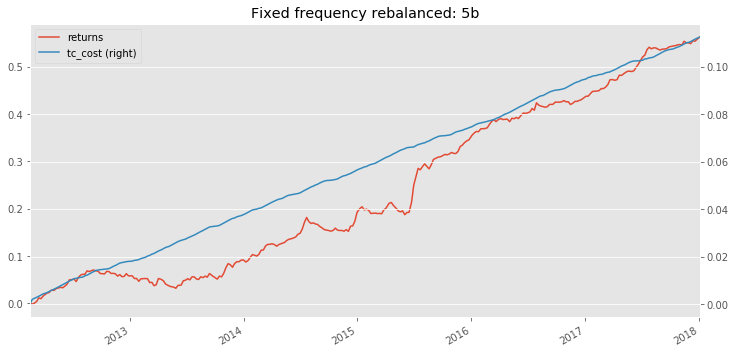

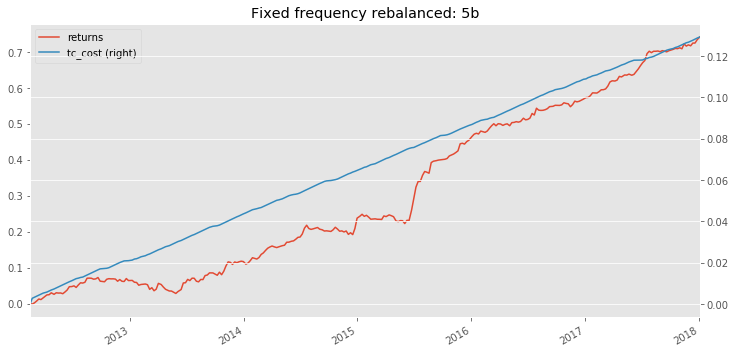

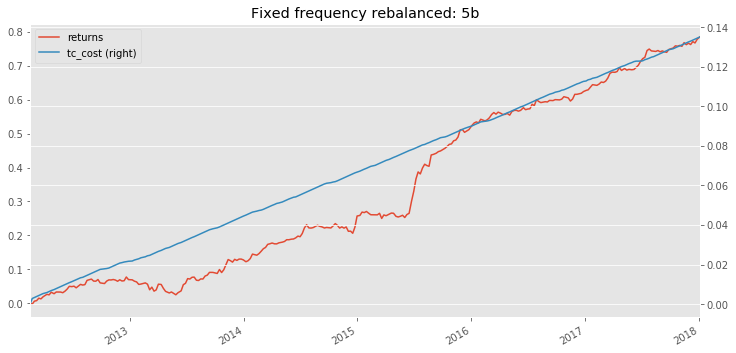

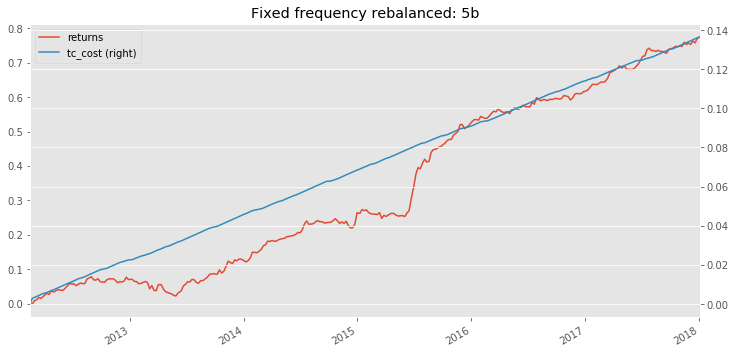

In [8]:
# Predicting and re-balance phase

weight_gaps = [0.01, 0.02, 0.03, 0.04]

model1_weight = 1.0
model2_weight = 0.5

factor_groups = const_model_factor_data.groupby('trade_date')

for weight_gap in weight_gaps:
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[total_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        industry = total_data.industry_code.values
        benchmark_w = total_data.weight.values

        constraint_exp = total_data[constraint_risk].values
        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for i, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i],
                                           upper_bound=risk_target[i])
            elif name == 'SIZE':
                base_target = abs(risk_target[i])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i] + base_target * size_risk_lower,
                                           upper_bound=risk_target[i] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[i] * industry_lower,
                                           upper_bound=risk_target[i] * industry_upper)
        
        factor_values = factor_processing(total_data[const_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)
        
        try:
            model = models_series.ix[date]
        except KeyError:
            alpha_logger.info("model is not available. Omit this date")
            continue
            
        index_dates.append(date)

        # x = predict_x[date]
        x = predict_x[date]
        risk = predict_risk[date][:, 1:]
        this_predict_code = predict_code[date]
        
        new_x = cross_product(x, risk)
        er2 = model.predict(new_x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': this_predict_code})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using backbone model and alpha model')
            er = model1_weight * er1 / er1.std() +  model2_weight * er2 / er2.std()
        else:
            print('using only backbone modedl')
            er = model1_weight * er1
            
        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  use_rank=use_rank,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  use_rank=use_rank,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, start_date, end_date, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

    total_returns = 0.

    for i, ret in enumerate(ret_df['ret_after_tc']):
        date = ret_df.index[i]
        total_returns += ret
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})

        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
        res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

    res_df.to_csv('hs300_rf_{0}.csv'.format(int(weight_gap * 100)))